In [51]:
from qiskit import *
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.quantum_info import random_statevector, Statevector
from pymatching import Matching
import numpy as np
import json
import math
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

In [9]:
noiseC = noise.NoiseModel()
noiseC.add_all_qubit_quantum_error(noise.pauli_error([('X', 0.1), ('Y', 0.1), ('Z', 0.1), ('I', 0.7)]), ['id'])
basis_gates = noiseC.basis_gates

In [10]:
zeroState = list()
oneState = list()
with open("zero.json", "r") as fp:
    zeroState = json.load(fp)
with open("one.json", "r") as fp:
    oneState = json.load(fp)

In [11]:
s = QuantumRegister(9, 'data')
x = QuantumRegister(4, 'x-syndrome')
z = QuantumRegister(4, 'z-syndrome')

xi = ClassicalRegister(4, 'x-init')
zi = ClassicalRegister(4, 'z-init')
xf = ClassicalRegister(4, 'x-final')
zf = ClassicalRegister(4, 'z-final')

xl = QuantumRegister(1, 'x-logical')
zl = QuantumRegister(1, 'z-logical')
xm = ClassicalRegister(1, 'x-measure')
zm = ClassicalRegister(1, 'z-measure')

In [12]:
def init():
    crt = QuantumCircuit()
    crt.add_register(s)
    crt.add_register(x)
    crt.add_register(z)

    crt.add_register(xl)
    crt.add_register(zl)
    
    crt.add_register(xi)
    crt.add_register(zi)
    crt.add_register(xf)
    crt.add_register(zf)

    crt.add_register(xm)
    crt.add_register(zm)
    return crt

In [13]:
def initArb(a, b):
    crt = init()
    initState = list(map((lambda x, y: a * x + b * y), zeroState, oneState))
    crt.initialize(initState, s)
    stabilizer(crt)
    return crt

In [14]:
def initZero():
    crt = initRand()
    synMeasure(crt, xi, zi)
    measureZ(crt)
    crt.x(range(3)).c_if(zm, 1)

    return crt

In [15]:
def initRand():
    crt = init()
    randomState = random_statevector(2 ** 9)
    crt.initialize(randomState.data, s)
    return crt

In [16]:
def stabilizer(crt):
    crt.h(s)
    crt.cnot(s[0], x[0])
    crt.cnot(s[1], x[0])
    crt.cnot(s[3], x[0])
    crt.cnot(s[4], x[0])
    crt.cnot(s[2], x[1])
    crt.cnot(s[5], x[1])
    crt.cnot(s[3], x[2])
    crt.cnot(s[6], x[2])
    crt.cnot(s[4], x[3])
    crt.cnot(s[5], x[3])
    crt.cnot(s[7], x[3])
    crt.cnot(s[8], x[3])
    crt.barrier()
    crt.h(s)
    
    crt.cnot(s[0], z[0])
    crt.cnot(s[1], z[0])
    crt.cnot(s[1], z[1])
    crt.cnot(s[2], z[1])
    crt.cnot(s[4], z[1])
    crt.cnot(s[5], z[1])
    crt.cnot(s[3], z[2])
    crt.cnot(s[4], z[2])
    crt.cnot(s[6], z[2])
    crt.cnot(s[7], z[2])
    crt.cnot(s[7], z[3])
    crt.cnot(s[8], z[3])


In [17]:
def synMeasure(crt, c1, c2):
    crt.reset(x)
    crt.reset(z)
    stabilizer(crt)
    crt.measure(x, c1)
    crt.measure(z, c2)

In [18]:
def measureZ(crt):
    crt.reset(zl)
    crt.barrier()
    crt.cnot(s[0], zl[0])
    crt.cnot(s[3], zl[0])
    crt.cnot(s[6], zl[0])

    crt.measure(zl, zm)
    crt.reset(zl)

In [19]:
def measureX(crt):
    crt.reset(xl)
    crt.barrier()
    crt.h(range(3))
    crt.cnot(s[0], xl[0])
    crt.cnot(s[1], xl[0])
    crt.cnot(s[2], xl[0])
    crt.h(range(3))
    crt.measure(xl, xm)
    crt.reset(xl)

In [20]:
def logicalX(crt):
    crt.x(range(3))

In [21]:
def logicalZ(crt):
    crt.z(0)
    crt.z(3)
    crt.z(6)

In [15]:
def ecc(crt):
    crt.x(0).c_if(c, )

In [22]:
#crt = initArb(1/math.sqrt(2), 1/math.sqrt(2))
# crt = initRand()

# stabilizer(crt)
# measureZ(crt, 0)
# # measureZ(crt)
# # crt.x(range(3)).c_if(zm, 1)
# syndrome(crt)
# crt.barrier()
# crt.cnot(s[0], xl[0])
# crt.cnot(s[3], xl[0])
# crt.cnot(s[6], xl[0])

qasm = Aer.get_backend('qasm_simulator')
state = Aer.get_backend('statevector_simulator')

In [17]:
result = execute(crt, backend = qasm, shots = 128).result()
print(result.get_counts(crt))

{'0 0 0000 0000 0000 0000': 1, '0 0 0000 0000 0001 0000': 1, '0 0 0000 0000 0001 0001': 1, '0 0 0000 0000 0001 0011': 1, '0 0 0000 0000 0001 0100': 2, '0 0 0000 0000 0001 0110': 2, '0 0 0000 0000 0001 1000': 3, '0 0 0000 0000 0001 1010': 1, '0 0 0000 0000 0001 1011': 1, '0 0 0000 0000 0001 1110': 1, '0 0 0000 0000 0010 0011': 1, '0 0 0000 0000 0010 0100': 2, '0 0 0000 0000 0010 0101': 1, '0 0 0000 0000 0010 0110': 1, '0 0 0000 0000 0010 1001': 1, '0 0 0000 0000 0010 1011': 1, '0 0 0000 0000 0011 0000': 2, '0 0 0000 0000 0011 0001': 2, '0 0 0000 0000 0011 0011': 1, '0 0 0000 0000 0011 1000': 5, '0 0 0000 0000 0011 1001': 2, '0 0 0000 0000 0011 1100': 1, '0 0 0000 0000 0011 1111': 1, '0 0 0000 0000 0100 0001': 1, '0 0 0000 0000 0100 0010': 1, '0 0 0000 0000 0100 0011': 1, '0 0 0000 0000 0100 0100': 2, '0 0 0000 0000 0100 1000': 1, '0 0 0000 0000 0100 1001': 1, '0 0 0000 0000 0101 0111': 1, '0 0 0000 0000 0101 1001': 1, '0 0 0000 0000 0110 0000': 1, '0 0 0000 0000 0110 0010': 1, '0 0 0000

In [18]:
for k in result.get_counts(crt).keys():
    print(k[0])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [19]:
crt = initZero()
crt.x(4)
measureZ(crt)
result = execute(crt, backend = qasm, shots = 128).result()
print(result.get_counts(crt))
for k in result.get_counts(crt).keys():
    print(k[0])

{'0 0 0000 0000 0000 0000': 1, '0 0 0000 0000 0001 0010': 1, '0 0 0000 0000 0001 0011': 2, '0 0 0000 0000 0001 0100': 2, '0 0 0000 0000 0001 0101': 1, '0 0 0000 0000 0001 0110': 1, '0 0 0000 0000 0001 0111': 1, '0 0 0000 0000 0001 1011': 1, '0 0 0000 0000 0001 1100': 1, '0 0 0000 0000 0001 1111': 1, '0 0 0000 0000 0010 0000': 2, '0 0 0000 0000 0010 1000': 1, '0 0 0000 0000 0010 1001': 1, '0 0 0000 0000 0010 1010': 2, '0 0 0000 0000 0010 1100': 1, '0 0 0000 0000 0010 1111': 1, '0 0 0000 0000 0000 0011': 1, '0 0 0000 0000 0011 0000': 2, '0 0 0000 0000 0011 0001': 1, '0 0 0000 0000 0011 0010': 1, '0 0 0000 0000 0011 0110': 1, '0 0 0000 0000 0011 0111': 1, '0 0 0000 0000 0100 0001': 1, '0 0 0000 0000 0100 0010': 1, '0 0 0000 0000 0100 1001': 1, '0 0 0000 0000 0100 1011': 2, '0 0 0000 0000 0101 0000': 1, '0 0 0000 0000 0101 0001': 3, '0 0 0000 0000 0101 0011': 1, '0 0 0000 0000 0101 1001': 1, '0 0 0000 0000 0101 1011': 1, '0 0 0000 0000 0101 1110': 1, '0 0 0000 0000 0101 1111': 2, '0 0 0000

In [20]:
crt = initZero()
crt.y(4)
synMeasure(crt, xf, zf)
measureX(crt)

result = execute(crt, 
                 backend = qasm,
                 basis_gates = noiseC.basis_gates, 
                 noise_model = noiseC,
                 shots = 128).result()
print(result.get_counts(crt))

{'0 1 0000 0011 0110 1010': 1, '0 1 0000 1011 0110 0010': 1, '0 1 0000 1110 0110 0111': 1, '0 1 0001 0111 0111 1110': 1, '0 1 0010 0111 0100 1110': 1, '0 1 0010 1000 0100 0001': 1, '0 1 0011 0001 0101 1000': 2, '0 1 0011 0111 0101 1110': 1, '0 1 0100 0100 0010 1101': 1, '0 1 0100 0101 0010 1100': 1, '0 1 0101 0110 0011 1111': 1, '0 1 0101 1110 0011 0111': 1, '0 0 0001 0110 0111 1111': 1, '0 1 0111 0000 0001 1001': 1, '0 1 1000 0000 1110 1001': 1, '0 1 1000 0100 1110 1101': 1, '0 1 1000 0110 1110 1111': 1, '0 1 1001 0000 1111 1001': 1, '0 1 1001 0101 1111 1100': 1, '0 1 1001 0110 1111 1111': 1, '0 1 1001 1101 1111 0100': 1, '0 1 1010 0101 1100 1100': 1, '0 1 1010 0110 1100 1111': 1, '0 1 1010 1100 1100 0101': 1, '0 1 1011 1000 1101 0001': 1, '0 1 1011 1101 1101 0100': 1, '0 1 1100 0001 1010 1000': 2, '0 1 1100 0010 1010 1011': 1, '0 1 1101 0000 1011 1001': 1, '0 1 1111 0111 1001 1110': 1, '0 1 1111 1010 1001 0011': 1, '1 0 0000 1010 0110 0011': 1, '1 0 0000 1101 0110 0100': 1, '1 0 0001

In [21]:
zero = 0
one = 0
for k, v in result.get_counts(crt).items():
    if k[2] == '0':
        zero = zero + v
    if k[2] =='1':
        one = one + v
print("zero: ", zero)
print("one: ", one)

zero:  59
one:  69


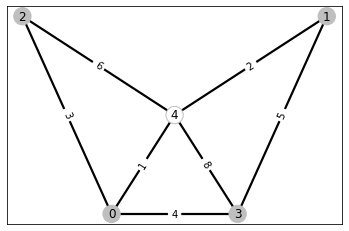

In [23]:
sz = np.array([
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1]
])

sx = np.array([
    [1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 1]
])
mz = Matching(sz)
mx = Matching(sx)
#mz.draw()
mx.draw()

In [23]:
crt.id(s)
crt.id(s)
synMeasure(crt, xf, zf)
result = execute(crt, 
                 backend = qasm,
                 basis_gates = noiseC.basis_gates, 
                 noise_model = noiseC,
                 shots = 1).result()
print(result.get_counts(crt))

{'1 1 1011 0101 1000 1001': 1}


In [24]:
res = list(result.get_counts(crt).keys())[0]
svx = np.array([0, 0, 0, 0])
svz = np.array([0, 0, 0, 0])
for i in range(4):
    if res[17 - i] == res[7 - i]:
        svx[i] = 0
    else: svx[i] = 1
    if res[12 - i] == res[22 - i]:
        svz[i] = 0
    else: svz[i] = 1
        
print(svx)
print(svz)

[1 1 0 0]
[0 0 1 1]


In [25]:
mx.decode(svx)

array([1, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [26]:
mz.decode(svz)

array([0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

In [27]:
crt = initZero()
crt.id(0)
synMeasure(crt, xf, zf)
measureZ(crt)
result = execute(crt, 
                 backend = qasm,
                 basis_gates = noiseC.basis_gates, 
                 noise_model = noiseC,
                 shots = 1024).result()


In [44]:
def tabulate(result, crt):
    zero_i = 0
    one_i = 0
    zero_f = 0
    one_f = 0
    for k, v in result.get_counts(crt).items():
        svx = np.array([0, 0, 0, 0])
        svz = np.array([0, 0, 0, 0])
        for i in range(4):
            if k[17 - i] == k[7 - i]:
                svz[i] = 0
            else: svz[i] = 1
            if k[12 - i] == k[22 - i]:
                svx[i] = 0
            else: svx[i] = 1
        ex = mx.decode(svx)
        ez = mz.decode(svz)
        corrected = (int(k[0]) + ez[0] + ez[3] + ez[6]) % 2
        if int(k[0]) == 0: zero_i = zero_i + v
        else: one_i = one_i + v
        if corrected == 0: zero_f = zero_f + v
        else: one_f = one_f + v
        #print(k, svz, ez, corrected)
#     print("init zero: ", zero_i)
#     print("init one: ", one_i)
#     print("final zero: ", zero_f)
#     print("final one: ", one_f)
#     print("sum: ", zero_i + one_i)
    return([zero_i, zero_f])

In [45]:
def test(p, s):
    crt = initZero()
    crt.rx(p, 0)
    crt.rx(p, 1)
    crt.rx(p, 2)
    synMeasure(crt, xf, zf)
    measureZ(crt)
    result = execute(crt, 
                     backend = qasm,
                     shots = s).result()

    return(tabulate(result, crt))

In [48]:
correction_eff = list()
for i in range(62):
    print(i)
    a = test(i / 20, 100)
    if a[0] == 100:
        if a[1] == 100:
            correction_eff.append(1)
        else:
            correction_eff.append(a[1] - a[0])
    else:
        correction_eff.append((a[1] - a[0]) / (100 - a[0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


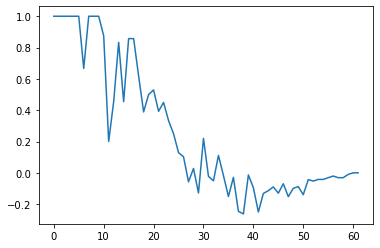

In [49]:
plt.plot(correction_eff)

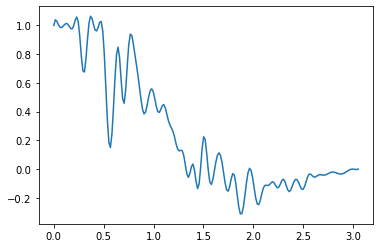

In [61]:
x = np.array(range(62))
x = x / 20
y = np.array(correction_eff)
xnew = np.linspace(x.min(), x.max(), 200)
spl = make_interp_spline(x, y, k = 5)
y_smooth = spl(xnew)
plt.plot(xnew, y_smooth)